# LSTM Ensemble - 2 Structure and 2 Phase

- Combine two models with different structures
- Combine two models with different angle setting

# Models to ensemble

In [1]:
model_orgnl_names = [
    "PointPicker_mpc128bin16_LSTM128DENSE64_10epc1e-4",
    "PointPicker_mpc128bin16_LSTM160DENSE0_10epc1e-4",
    "PointPicker_mpc128bin16_LSTM128DENSE64_10epc1e-4_10epc1e-5",
    "PointPicker_mpc128bin16_LSTM160DENSE0_10epc1e-4_10epc1e-5",
]
model_shift_names = [
    "PPAS_mpc128bin16_LSTM128DENSE64_10epc1e-4",
    "PPAS_mpc128bin16_LSTM160DENSE0_10epc1e-4",
]

# Set-up

- Import packages
- Set hyperparameters

In [2]:
# Data I/O and preprocessing
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# System
import time
import os
import gc

# Graphic
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm

# multiprocessing
import multiprocessing

# TENSORFLOW
import tensorflow as tf

In [3]:
# directory
model_dir = "/kaggle/input/icecubemodels/"
data_dir = "/kaggle/input/icecubedata/"

In [4]:
# data
# available: 101 - 105
batch_ids = [101]
point_picker_format = data_dir + './pointpicker_mpc128_n9_batch_{batch_id:d}.npz'

# Load Models

In [5]:
model_orgnls = list()
for model_name in model_orgnl_names:
    print(model_name)
    
    model_path = model_dir + model_name
    model = tf.keras.models.load_model(model_path)
    model.summary()
    
    model_orgnls.append(model)
    
model_shifts = list()
for model_name in model_shift_names:
    print(model_name)
    
    model_path = model_dir + model_name
    model = tf.keras.models.load_model(model_path)
    model.summary()
    
    model_shifts.append(model)

PointPicker_mpc128bin16_LSTM128DENSE64_10epc1e-4


2023-02-02 18:46:12.194079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:46:12.195019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:46:12.200998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:46:12.201731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:46:12.202449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               141312    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
Total params: 174,400
Trainable params: 174,400
Non-trainable params: 0
_________________________________________________________________
PointPicker_mpc128bin16_LSTM160DENSE0_10epc1e-4
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 9)]          0  

In [6]:
max_pulse_count = model_orgnls[0].inputs[0].shape[1]
n_features = model_orgnls[0].inputs[0].shape[2]
output_bins = model_orgnls[0].layers[-1].weights[0].shape[-1]

bin_num = int(np.sqrt(output_bins))

print("    bin_num    : ", bin_num)
print("max_pulse_count: ", max_pulse_count)
print("   n_features  : ", n_features)

    bin_num    :  16
max_pulse_count:  128
   n_features  :  9


# Data I/O Helper

## Angle one-hot encoding edges

- It is efficient to train the model by classification task, initially.
- azimuth and zenith are independent
- azimuth distribution is flat and zenith distribution is sinusoidal.
  - Flat on the spherical surface
  - $\phi > \pi$ events are a little bit rarer than $\phi < \pi$ events, (maybe) because of the neutrino attenuation by earth.
- So, the uniform bin is used for azimuth, and $\left| \cos \right|$ bin is used for zenith

In [7]:
azimuth_edges = np.linspace(0, 2 * np.pi, bin_num + 1)
azimuth_shift = (azimuth_edges[1] - azimuth_edges[0]) / 2.

zenith_edges_flat = np.linspace(0, np.pi, bin_num + 1)
zenith_edges = list()
zenith_edges.append(0)
for bin_idx in range(1, bin_num):
    # cos(zen_before) - cos(zen_now) = 2 / bin_num
    zen_now = np.arccos(np.cos(zenith_edges[-1]) - 2 / (bin_num))
    zenith_edges.append(zen_now)
zenith_edges.append(np.pi)
zenith_edges = np.array(zenith_edges)

In [8]:
def y_to_onehot(batch_y):
    # evaluate bin code
    azimuth_code = (batch_y[:, 0] > azimuth_edges[1:].reshape((-1, 1))).sum(axis=0)
    zenith_code = (batch_y[:, 1] > zenith_edges[1:].reshape((-1, 1))).sum(axis=0)
    angle_code = bin_num * azimuth_code + zenith_code

    # one-hot
    batch_y_onehot = np.zeros((angle_code.size, bin_num * bin_num))
    batch_y_onehot[np.arange(angle_code.size), angle_code] = 1
    
    return batch_y_onehot

## Define a function converts from prediction to angles

- Calculation of the mean-vector in a bin $\theta \in ( \theta_0, \theta_1 )$ and $\phi \in ( \phi_0, \phi_1 )$
  - $\vec{r} \left( \theta, ~ \phi \right) = \left< \sin \theta \cos \phi, ~ \sin \theta \sin \phi, ~ \cos \theta \right>$
  - $\bar{\vec{r}} = \frac{ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \vec{r} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta }{ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} 1 \sin \theta \,d\phi \,d\theta }$
  - $ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} 1 \sin \theta \,d\phi \,d\theta = \left( \phi_1 - \phi_0 \right) \left( \cos \theta_0 - \cos \theta_1 \right)$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{x} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin^2 \theta \cos \phi \,d\phi \,d\theta = 
\left( \sin \phi_1 - \sin \phi_0 \right) \left( \frac{\theta_1 - \theta_0}{2} - \frac{\sin 2 \theta_1 - \sin 2 \theta_0}{4} \right)
$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{y} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin^2 \theta \sin \phi \,d\phi \,d\theta = 
\left( \cos \phi_0 - \cos \phi_1 \right) \left( \frac{\theta_1 - \theta_0}{2} - \frac{\sin 2 \theta_1 - \sin 2 \theta_0}{4} \right)
$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{z} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin \theta \cos \theta \,d\phi \,d\theta = 
\left( \phi_1 - \phi_0 \right) \left( \frac{\cos 2 \theta_0 - \cos 2 \theta_1}{4} \right)
$

In [9]:
angle_bin_zenith0 = np.tile(zenith_edges[:-1], bin_num)
angle_bin_zenith1 = np.tile(zenith_edges[1:], bin_num)
angle_bin_azimuth0 = np.repeat(azimuth_edges[:-1], bin_num)
angle_bin_azimuth1 = np.repeat(azimuth_edges[1:], bin_num)

angle_bin_area = (angle_bin_azimuth1 - angle_bin_azimuth0) * (np.cos(angle_bin_zenith0) - np.cos(angle_bin_zenith1))
angle_bin_vector_sum_x = (np.sin(angle_bin_azimuth1) - np.sin(angle_bin_azimuth0)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_y = (np.cos(angle_bin_azimuth0) - np.cos(angle_bin_azimuth1)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_z = (angle_bin_azimuth1 - angle_bin_azimuth0) * ((np.cos(2 * angle_bin_zenith0) - np.cos(2 * angle_bin_zenith1)) / 4)

angle_bin_vector_mean_x = angle_bin_vector_sum_x / angle_bin_area
angle_bin_vector_mean_y = angle_bin_vector_sum_y / angle_bin_area
angle_bin_vector_mean_z = angle_bin_vector_sum_z / angle_bin_area

angle_bin_vector = np.zeros((1, bin_num * bin_num, 3))
angle_bin_vector[:, :, 0] = angle_bin_vector_mean_x
angle_bin_vector[:, :, 1] = angle_bin_vector_mean_y
angle_bin_vector[:, :, 2] = angle_bin_vector_mean_z

angle_bin_vector_unit = angle_bin_vector[0].copy()
angle_bin_vector_unit /= np.sqrt((angle_bin_vector_unit**2).sum(axis=1).reshape((-1, 1)))

In [10]:
def pred_to_angle(pred, epsilon=1e-8):
    # convert prediction to vector
    pred_vector = (pred.reshape((-1, bin_num * bin_num, 1)) * angle_bin_vector).sum(axis=1)
    
    # normalize
    pred_vector_norm = np.sqrt((pred_vector**2).sum(axis=1))
    mask = pred_vector_norm < epsilon
    pred_vector_norm[mask] = 1
    
    # assign <1, 0, 0> to very small vectors (badly predicted)
    pred_vector /= pred_vector_norm.reshape((-1, 1))
    pred_vector[mask] = np.array([1., 0., 0.])
    
    # convert to angle
    azimuth = np.arctan2(pred_vector[:, 1], pred_vector[:, 0])
    azimuth[azimuth < 0] += 2 * np.pi
    zenith = np.arccos(pred_vector[:, 2])
    
    # mask bad norm predictions as 0, 0
    azimuth[mask] = 0.
    zenith[mask] = 0.
    
    return azimuth, zenith


def pred_to_angle_azshift(pred, epsilon=1e-8):
    # convert prediction to vector
    pred_vector = (pred.reshape((-1, bin_num * bin_num, 1)) * angle_bin_vector).sum(axis=1)
    
    # normalize
    pred_vector_norm = np.sqrt((pred_vector**2).sum(axis=1))
    mask = pred_vector_norm < epsilon
    pred_vector_norm[mask] = 1
    
    # assign <1, 0, 0> to very small vectors (badly predicted)
    pred_vector /= pred_vector_norm.reshape((-1, 1))
    pred_vector[mask] = np.array([1., 0., 0.])
    
    # convert to angle
    azimuth = np.arctan2(pred_vector[:, 1], pred_vector[:, 0])
    azimuth[azimuth < 0] += 2 * np.pi
    zenith = np.arccos(pred_vector[:, 2])
    
    # shift
    azimuth -= azimuth_shift
    azimuth[azimuth < 0] += 2 * np.pi
    
    # mask bad norm predictions as 0, 0
    azimuth[mask] = 0.
    zenith[mask] = 0.
    
    return azimuth, zenith

## Scoring functions

In [11]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))


def angular_dist_score_samples(az_true, zen_true, az_pred, zen_pred):
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.abs(np.arccos(scalar_prod))

# Read Feature Data

In [12]:
print("Reading training data...")

train_x = None
train_y = None
for batch_id in tqdm(batch_ids):
    train_data_file = np.load(point_picker_format.format(batch_id=batch_id))
    
    if train_x is None:
        train_x = train_data_file["x"]
        train_y = train_data_file["y"]
    else:
        train_x = np.append(train_x, train_data_file["x"], axis=0)
        train_y = np.append(train_y, train_data_file["y"], axis=0)
        
    train_data_file.close()
    del train_data_file
    _ = gc.collect()

# normalization and one-hot encoding
train_x[:, :, 0] /= 1000  # time
train_x[:, :, 1] /= 300  # charge
train_x[:, :, 3:] /= 600  # space

# train_y_onehot = y_to_onehot(train_y)

train_y = train_y.astype("float32")
az_true = train_y[:, 0]
zen_true = train_y[:, 1]

Reading training data...


100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


# Predict and Evaluate angles by single models

In [13]:
pred_orgnls = [model.predict(train_x, verbose=1) for model in model_orgnls]
pred_shifts = [model.predict(train_x, verbose=1) for model in model_shifts]

2023-02-02 18:46:57.181046: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 921600000 exceeds 10% of free system memory.
2023-02-02 18:46:58.234292: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 921600000 exceeds 10% of free system memory.
2023-02-02 18:46:59.019819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-02 18:47:01.210809: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6250/6250 [==============================] - 50s 7ms/step


2023-02-02 18:48:22.398118: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 921600000 exceeds 10% of free system memory.
2023-02-02 18:48:23.438961: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 921600000 exceeds 10% of free system memory.


6250/6250 [==============================] - 45s 7ms/step


2023-02-02 18:49:10.274325: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 921600000 exceeds 10% of free system memory.


6250/6250 [==============================] - 45s 7ms/step


In [14]:
gc.collect()

4347

In [15]:
angle_orgnls = list()
mae_orgnls = list()
for pred in pred_orgnls:
    az_pred, zen_pred = pred_to_angle(pred)
    angle_orgnls.append([az_pred, zen_pred])
    mae_orgnls.append(angular_dist_score_samples(az_true, zen_true, az_pred, zen_pred))

angle_shifts = list()
mae_shifts = list()
for pred in pred_shifts:
    az_pred, zen_pred = pred_to_angle_azshift(pred)
    angle_shifts.append([az_pred, zen_pred])
    mae_shifts.append(angular_dist_score_samples(az_true, zen_true, az_pred, zen_pred))

## Draw scatter plot

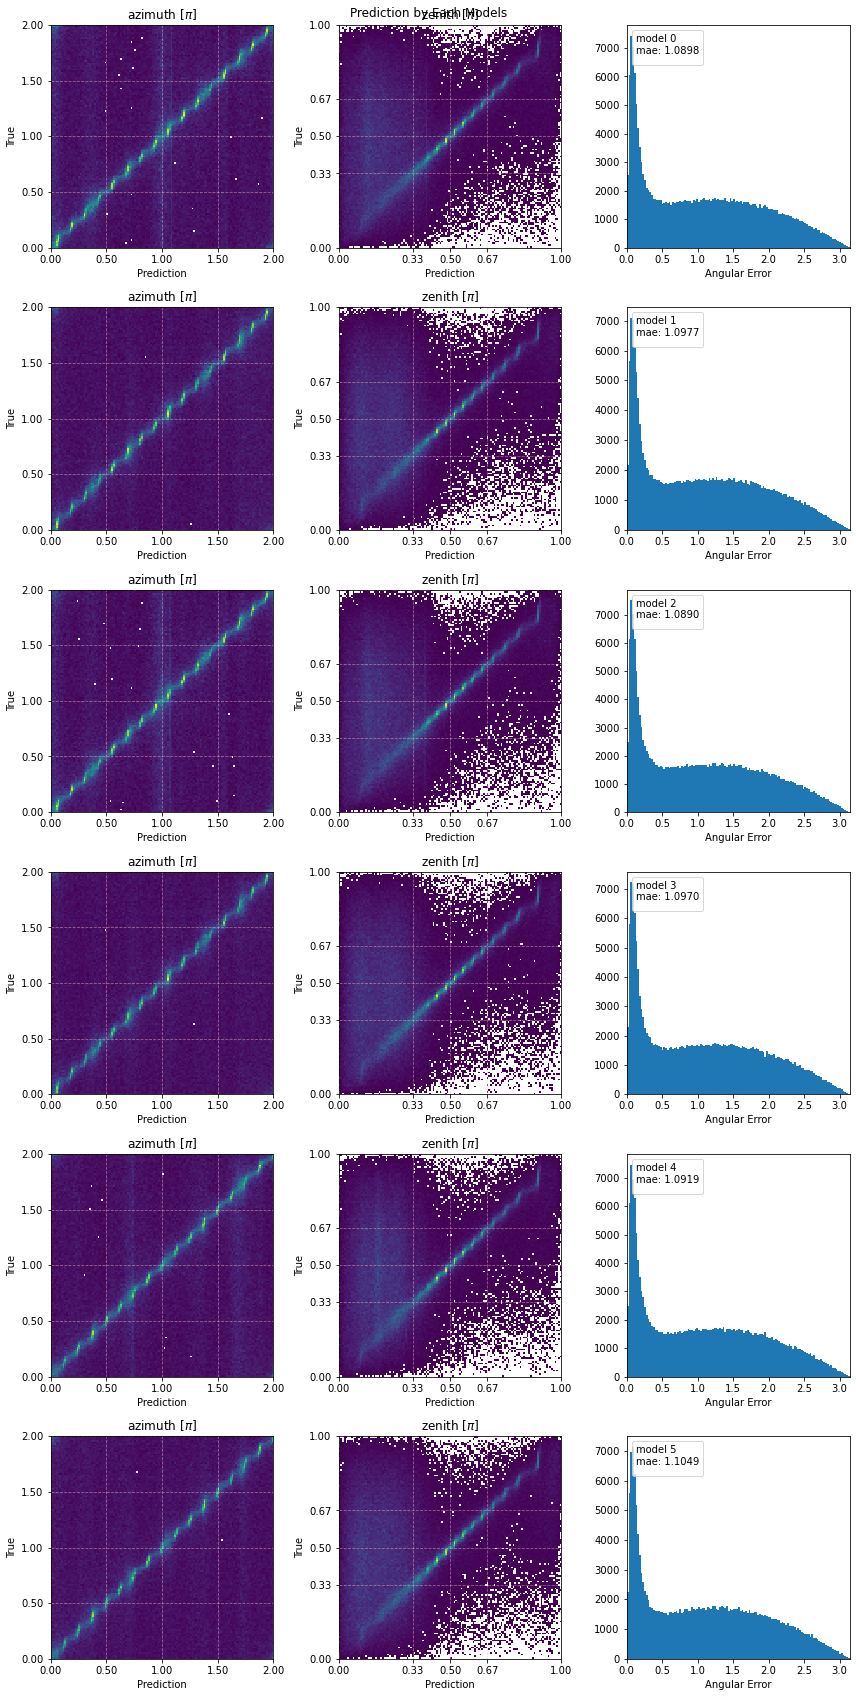

In [16]:
fig, axs = plt.subplots(len(model_orgnls) + len(model_shifts), 3, figsize=(12, 4 * (len(model_orgnls) + len(model_shifts))))

for model_idx in range(len(model_orgnls)):
    az_pred, zen_pred = angle_orgnls[model_idx]
    mae = mae_orgnls[model_idx]
    
    # azimuth
    ax = axs[model_idx, 0]
    ax.hist2d(az_pred, az_true, bins=np.linspace(0, 2 * np.pi, 128 + 1), cmin=1)
    
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(0, 2 * np.pi)
    ax.set_xticks(azimuth_edges[0::(bin_num//4)])
    ax.set_xticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
    ax.set_yticks(azimuth_edges[0::(bin_num//4)])
    ax.set_yticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
    ax.grid(linestyle="dashed", color="pink", alpha=0.5)
    ax.set_title(r"azimuth [$\pi$]")
    
    # zenith
    ax = axs[model_idx, 1]
    ax.hist2d(zen_pred, zen_true, bins=np.linspace(0, np.pi, 128 + 1), cmin=1)
    
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    ax.set_xlim(0, np.pi)
    ax.set_ylim(0, np.pi)
    ax.set_xticks(zenith_edges[0::(bin_num//4)])
    ax.set_xticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
    ax.set_yticks(zenith_edges[0::(bin_num//4)])
    ax.set_yticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
    ax.grid(linestyle="dashed", color="pink", alpha=0.5)
    ax.set_title(r"zenith [$\pi$]")
    
    # angular error
    ax = axs[model_idx, 2]
    ax.hist(mae, bins=128, range=(0, np.pi))
    
    ax.set_xlabel("Angular Error")
    ax.set_xlim(0, np.pi)
    ax.legend(title=f"model {model_idx:d}\nmae: {mae.mean():.4f}", loc="upper left")

for model_idx in range(len(model_orgnls), len(model_orgnls) + len(model_shifts)):
    az_pred, zen_pred = angle_shifts[model_idx - len(model_orgnls)]
    mae = mae_shifts[model_idx - len(model_orgnls)]
    
    # azimuth
    ax = axs[model_idx, 0]
    ax.hist2d(az_pred, az_true, bins=np.linspace(0, 2 * np.pi, 128 + 1), cmin=1)
    
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(0, 2 * np.pi)
    ax.set_xticks(azimuth_edges[0::(bin_num//4)])
    ax.set_xticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
    ax.set_yticks(azimuth_edges[0::(bin_num//4)])
    ax.set_yticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
    ax.grid(linestyle="dashed", color="pink", alpha=0.5)
    ax.set_title(r"azimuth [$\pi$]")
    
    # zenith
    ax = axs[model_idx, 1]
    ax.hist2d(zen_pred, zen_true, bins=np.linspace(0, np.pi, 128 + 1), cmin=1)
    
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    ax.set_xlim(0, np.pi)
    ax.set_ylim(0, np.pi)
    ax.set_xticks(zenith_edges[0::(bin_num//4)])
    ax.set_xticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
    ax.set_yticks(zenith_edges[0::(bin_num//4)])
    ax.set_yticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
    ax.grid(linestyle="dashed", color="pink", alpha=0.5)
    ax.set_title(r"zenith [$\pi$]")
    
    # angular error
    ax = axs[model_idx, 2]
    ax.hist(mae, bins=128, range=(0, np.pi))
    
    ax.set_xlabel("Angular Error")
    ax.set_xlim(0, np.pi)
    ax.legend(title=f"model {model_idx:d}\nmae: {mae.mean():.4f}", loc="upper left")

plt.suptitle("Prediction by Each Models")
plt.tight_layout()
plt.show()

# Develope Ensemble

## Vector Weighted Mean

In [17]:
vec_orgnls = list()
for angle in tqdm(angle_orgnls):
    az, zen = angle
    
    sa = np.sin(az)
    ca = np.cos(az)
    sz = np.sin(zen)
    cz = np.cos(zen)
    
    vec = np.stack([sz * ca, sz * sa, cz], axis=1)
    vec_orgnls.append(vec)

vec_shifts = list()
for angle in tqdm(angle_shifts):
    az, zen = angle
    
    sa = np.sin(az)
    ca = np.cos(az)
    sz = np.sin(zen)
    cz = np.cos(zen)
    
    vec = np.stack([sz * ca, sz * sa, cz], axis=1)
    vec_shifts.append(vec)

100%|██████████| 2/2 [00:00<00:00, 51.74it/s]


In [18]:
vec_models = np.array(vec_orgnls + vec_shifts)

In [19]:
def weghted_mean_ensemble(weight=np.ones(len(model_orgnls) + len(model_shifts)) / (len(model_orgnls) + len(model_shifts))):
    vec_mean = (weight.reshape((-1, 1, 1)) * vec_models).sum(axis=0) / weight.sum()
    vec_mean /= np.sqrt((vec_mean**2).sum(axis=1)).reshape((-1, 1))

    zenith = np.arccos(vec_mean[:, 2])
    azimuth = np.arctan2(vec_mean[:, 1], vec_mean[:, 0])
    azimuth[azimuth < 0] += 2 * np.pi
    
    return azimuth, zenith

In [20]:
def weight_evaluate(weight):
    az_pred, zen_pred = weghted_mean_ensemble(weight)
    return angular_dist_score(az_true, zen_true, az_pred, zen_pred)

In [21]:
weight_evaluate(np.array([1, 1, 1, 1, 1, 1]))

1.0808412092324775

In [22]:
weight_evaluate(np.array([2, 1, 0, 0, 2, 1]))

1.0796874251755464

In [23]:
weight_evaluate(np.array([0, 0, 3, 1, 3, 1]))

1.0793806095587861

In [24]:
weight_evaluate(np.array([0, 0, 3, 2, 3, 0.1]))

1.079098788408296

In [25]:
weight_evaluate(np.array([0, 0, 3, 2, 3, 0]))

1.0791143140909498

In [26]:
weight_evaluate(np.array([1, 0, 2, 1.5, 3, 0.5]))

1.0790160693528557

100%|██████████| 86/86 [00:04<00:00, 18.10it/s]


BEST
weights160:  0.22000000000000003
score:  1.0790768209708954


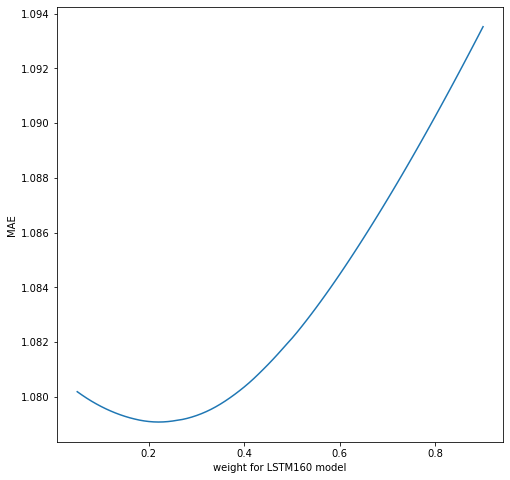

In [27]:
weights160 = np.linspace(0.05, 0.9, 86)
scores = list()
for weight160 in tqdm(weights160):
    weight = np.array([0, 0, (1 - weight160) / 2, weight160, (1 - weight160) / 2, 0])
    score = weight_evaluate(weight)
#     print(f"{weight160:.2f}, {score:.6f}")
    scores.append(score)
scores = np.array(scores)

print("BEST")
print("weights160: ", weights160[scores.argmin()])
print("score: ", scores.min())

# draw
fig = plt.figure(figsize=(8, 8))

plt.plot(weights160, scores)

plt.xlabel("weight for LSTM160 model")
plt.ylabel("MAE")
plt.show()

# END-OF-NOTE